<a href="https://colab.research.google.com/github/AllergictoCrustaceans/ML/blob/main/K_means_SVD_Heart_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Detect Heart Disease**

Prompt: Given biometrics of patient, detect the presence of heart disease. 

ML Problem Type: KMeans Clustering, TruncatedSVD, small dataset

What is data from: https://archive.ics.uci.edu/ml/datasets/heart+disease and it is labeled.

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import unique, where

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer, StandardScaler, OneHotEncoder, LabelEncoder
from scipy import sparse


### 1.) Load Dataset

In [31]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

"""
FEATURES: 
1.) (num.) age: the patient's age
2.) (ohe.) sex: the patient's sex (1 = male, 0 = female)
3.) (ohe.) cp: Chest pain type (1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic)
4.) (num.) trestbps: resting blood pressure (in mm Hg)
5.) (num.) chol: serum cholestoral in mg/dl
6.) (ohe.) fbs: fasthing blood sugar > 120 mg/dl (1 = True, 0 = False)
7.) (ohe.) restecg: resting electrocardiographics results (0 = normal, 1 = have ST-T wave abnormality via T wave inversions and/or ST elevation OR depression of > 0.05 mV)
8.) (num.) thalach: max heart rate achieved
9.) (ohe.) exang: exercised induced angina (1 = True, 0 = False)
10.) (num.) oldpeak: ST depression induced by exercise relative to rest
11.) (ohe.) slope: slope of the peak exercise ST segment (1 = upsloping, 2 = flat, 3 = downsloping)
12.) (ohe.) ca: number of major vessels (0-3) colored by floursopy
13.) (ohe.) thal: 3 = normal, 6 = fixed defect, 7 = reversable defect

LABEL:
14.) (ohe.) num: diagnosis of heart disease (angiographic disease status) (0 = <50% diameter narrowing, 1 = >50% diameter narrowing) 
but you see numbers (0-4) on the dataset instead. where anything that is NOT 0 has chance of heart disease being present. Otherwise, it is 0.

"""

ds_raw = pd.read_csv(url, header=0, names=column_names,
                          na_values='?', comment='\t',
                          sep=',', skipinitialspace=True)

### 2.) Inspect



In [32]:
# data info
ds_raw.info()
ds_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       302 non-null    float64
 1   sex       302 non-null    float64
 2   cp        302 non-null    float64
 3   trestbps  302 non-null    float64
 4   chol      302 non-null    float64
 5   fbs       302 non-null    float64
 6   restecg   302 non-null    float64
 7   thalach   302 non-null    float64
 8   exang     302 non-null    float64
 9   oldpeak   302 non-null    float64
 10  slope     302 non-null    float64
 11  ca        298 non-null    float64
 12  thal      300 non-null    float64
 13  num       302 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.2 KB


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0


Some things I immediately notice:

- All features' 'Dtype' are 'float64'. So, seems like categorical features have been encoded in some fashion already. 
-  Label's 'Dtype' is 'int64'. In order to keep consistency, I will make this a float.
- All features except 'ca', and 'thal' have 302 data entries. 

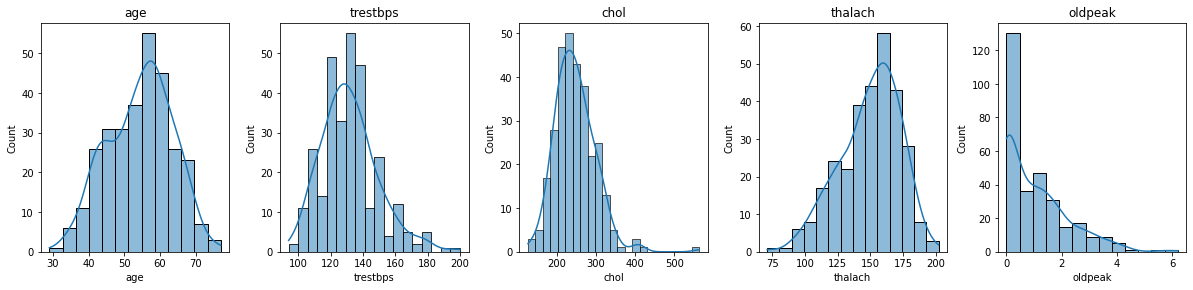

In [33]:
# check feature distribution. 
cols_to_norm = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
cols_to_ohe = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

plt.figure(figsize=(20, 15))
j = 0
for i in cols_to_norm:
    plt.subplot(4, 6, j + 1)
    sns.histplot(data=ds_raw[i], kde=True)
    plt.title(i)
    j += 1
plt.tight_layout()
plt.show()

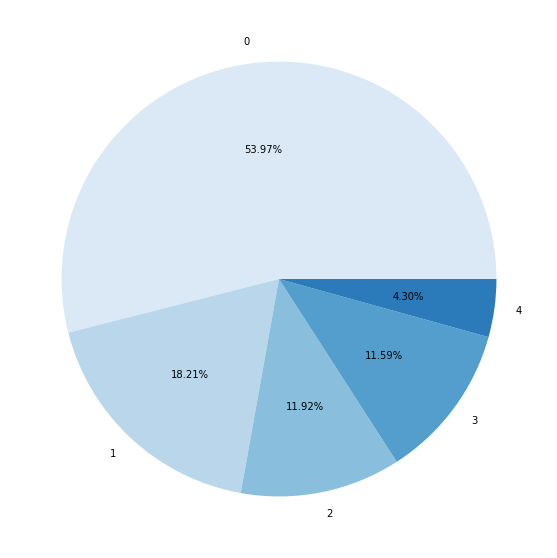

In [34]:
    plt.figure(figsize=(10, 10))
    plt.pie(ds_raw['num'].value_counts(),
            autopct='%0.2f%%',
            labels=[i for i in ds_raw['num'].value_counts().index],
            colors=sns.color_palette('Blues'))
    plt.show()

    # wtf does 0, 1, 2, 3, 4 mean?

### 3.) Clean

Since 'ca' and 'thal' are categorical features, I will fill the nulls with their most frequent value in their respective column.

In [35]:
#fill na of 'ca', and 'thal'
ds = ds_raw.copy()

ds['ca'].fillna(ds['ca'].mode()[0], inplace=True)
ds['thal'].fillna(ds['thal'].mode()[0], inplace=True)

### 4.) Preprocess

In [36]:
train_ds, test_ds = train_test_split(ds, test_size=0.3, stratify=ds['num'])

y_train = train_ds['num']
y_test = test_ds['num']

x_train = train_ds.drop('num', axis=1)
x_test = test_ds.drop('num', axis=1)

print('x_train: ', x_train.shape)
print('x_test: ', x_test.shape)
print('y_train: ', y_train.shape)
print('y_test: ', y_test.shape)

x_train:  (211, 13)
x_test:  (91, 13)
y_train:  (211,)
y_test:  (91,)


In [37]:
x_train_norm = x_train.filter(cols_to_norm, axis=1)
x_test_norm = x_test.filter(cols_to_norm, axis=1)

x_train_ohe = x_train.filter(cols_to_ohe, axis=1)
x_test_ohe = x_test.filter(cols_to_ohe, axis=1)

print(x_train_norm.shape)
print(x_test_norm.shape)
print(x_train_ohe.shape)
print(x_test_ohe.shape)

(211, 5)
(91, 5)
(211, 8)
(91, 8)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (211). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (91). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


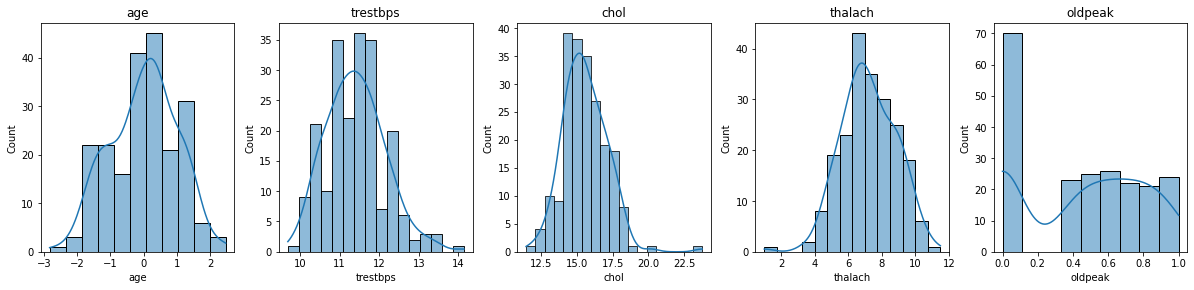

In [38]:
from sklearn.preprocessing import QuantileTransformer

# Normalize
# age is gaussian
x_train_norm['age'] = (x_train_norm['age'] - x_train_norm['age'].mean()) / x_train_norm['age'].std()
x_test_norm['age'] = (x_test_norm['age'] - x_test_norm['age'].mean()) / x_test_norm['age'].std()

# trestbps has slight right skew. try sqrt
x_train_norm['trestbps'] = np.sqrt(x_train_norm['trestbps'])
x_test_norm['trestbps'] = np.sqrt(x_test_norm['trestbps'])

# chol has slight right skew. try sqrt
x_train_norm['chol'] = np.sqrt(x_train_norm['chol'])
x_test_norm['chol'] = np.sqrt(x_test_norm['chol'])


# thalach has slight left skew. try log
x_train_norm['thalach'] = np.sqrt(max(x_train_norm['thalach']) + 1 - x_train_norm['thalach'])
x_test_norm['thalach'] = np.sqrt(max(x_test_norm['thalach']) + 1 - x_test_norm['thalach'])

# oldpeak has right skew. try bucketing. 
qt = QuantileTransformer()
oldpeak_train_norm = x_train_norm['oldpeak'].values
oldpeak_test_norm = x_test_norm['oldpeak'].values

x_train_norm['oldpeak'] = qt.fit_transform(oldpeak_train_norm.reshape(-1, 1))
x_test_norm['oldpeak'] = qt.fit_transform(oldpeak_test_norm.reshape(-1, 1))


# check feature distr again
plt.figure(figsize=(20, 15))
j = 0
for i in cols_to_norm:
    plt.subplot(4, 6, j + 1)
    sns.histplot(data=x_train_norm[i], kde=True)
    plt.title(i)
    j += 1
plt.tight_layout()
plt.show()

In [39]:
# Scale
scaler = StandardScaler()
x_train_norm = scaler.fit_transform(x_train_norm) # skip oldpeak
x_test_norm = scaler.transform(x_test_norm) # skip oldpeak

# OHE
ohe = OneHotEncoder()
x_train_ohe = ohe.fit_transform(x_train_ohe)
x_test_ohe = ohe.transform(x_test_ohe)

# le
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Array to Sparse Matrix
x_train_norm_sparse = sparse.csr_matrix(x_train_norm)
x_test_norm_sparse = sparse.csr_matrix(x_test_norm)

# Concat back into one 
x_train = sparse.hstack((x_train_norm_sparse, x_train_ohe))
x_test = sparse.hstack((x_test_norm_sparse, x_test_ohe))

In [40]:
print(x_test.shape)
print(x_train.shape)

(91, 28)
(211, 28)


In [41]:
# The entire data
ds_prepro = sparse.vstack((x_train, x_test))
print(ds_prepro.shape)

(302, 28)


### 5.) SVD

In [60]:
from sklearn.decomposition import TruncatedSVD
# create SVD instance
svd = TruncatedSVD(n_components=3)
svd_features = svd.fit_transform(ds_prepro)

# plot variances?

print(svd.singular_values_)

[35.39147256 26.24353004 19.95086672]


### 6.) KMeans


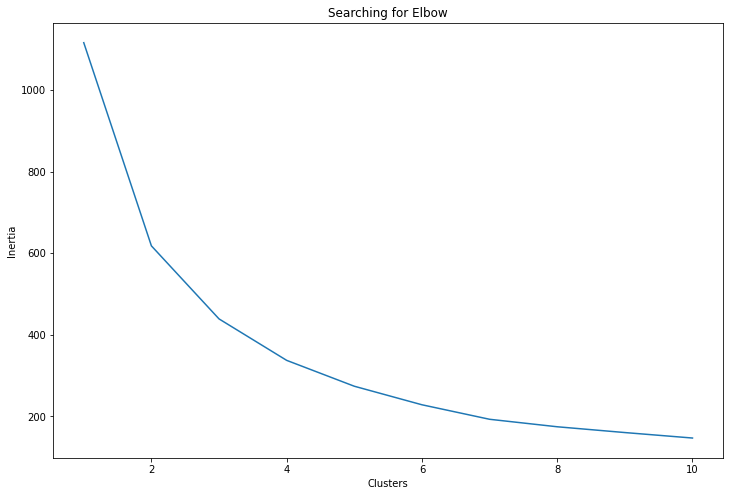

In [61]:
from sklearn.cluster import KMeans

clusters = []

for i in range(1, 11):
    km = KMeans(n_clusters=i).fit(svd_features)
    clusters.append(km.inertia_)
    
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=list(range(1, 11)), y=clusters, ax=ax)
ax.set_title('Searching for Elbow')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')
plt.show()

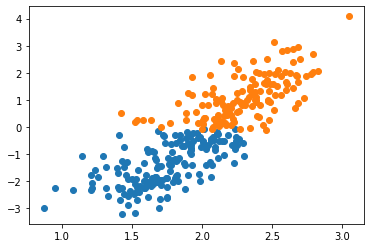

In [62]:
# With K=2
km_2 = KMeans(n_clusters=2)
km_2.fit(svd_features)
y_pred = km_2.predict(svd_features)
clusters = unique(y_pred)

for cluster in clusters:
    row_ix = where(y_pred == cluster)
    plt.scatter(svd_features[row_ix, 0], svd_features[row_ix, 1])

plt.show()

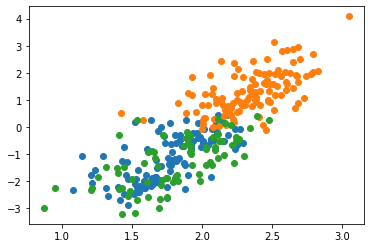

In [63]:
# With K=3
km_3 = KMeans(n_clusters=3)
km_3.fit(svd_features)
y_pred = km_3.predict(svd_features)
clusters = unique(y_pred)

for cluster in clusters:
    row_ix = where(y_pred == cluster)
    plt.scatter(svd_features[row_ix, 0], svd_features[row_ix, 1])

plt.show()

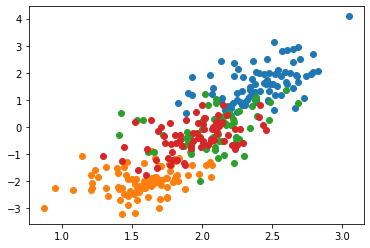

In [64]:
# With K=4
km_4 = KMeans(n_clusters=4)
km_4.fit(svd_features)
y_pred = km_4.predict(svd_features)
clusters = unique(y_pred)

for cluster in clusters:
    row_ix = where(y_pred == cluster)
    plt.scatter(svd_features[row_ix, 0], svd_features[row_ix, 1])

plt.show()

### 7.) Final Thoughts

- Clustering evaluation: since you have labels, you can use 'purity', and 'nmi' to evaluate clustering performance. 

- For now, can only classify between 2 classes (presence of heart disease, NO presence of heart disease)

- If you want to accurately classify based on the original data's labels (0-4), what should you do? 